(c) 2016 by Thomas Wiecki

Recently, I blogged about [Bayesian Deep Learning with PyMC3](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) where I built a simple hand-coded Bayesian Neural Network and fit it on a toy data set. Today, we will build a more interesting model using [Lasagne](https://lasagne.readthedocs.io/en/latest/), a flexible `Theano` library for constructing various types of Neural Networks. As you may know, [PyMC3](http://pymc-devs.github.io/pymc3/) is also using `Theano` so having the Artifical Neural Network (ANN) be built in `Lasagne`, but placing Bayesian priors on our parameters and then using variational inference (ADVI) in PyMC3 to estimate the model should be possible. To my delight, it is not only possible but also very straight forward.

Below, I will first show how to bridge `PyMC3` and `Lasagne` to build a dense 2-layer ANN. We'll then use mini-batch ADVI to fit the model on the MNIST handwritten digit data set. Then, we will follow up on another idea expressed in my [last blog post](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) -- hierarchical ANNs. Finally, due to the power of `Lasagne`, we can just as easily build a Hierarchical Bayesian Convolution ANN with max-pooling layers to achieve 98% accuracy on MNIST.

Most of the code used here is borrowed from the [Lasagne tutorial](http://lasagne.readthedocs.io/en/latest/user/tutorial.html).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as T
import theano

from scipy.stats import mode, chisquare

from sklearn.metrics import confusion_matrix, accuracy_score

import lasagne

## Data set: MNIST

We will be using the classic MNIST data set of handwritten digits. Contrary to my previous blog post which was limited to a toy data set, MNIST is an actually challenging ML task (of course not quite as challening as e.g. ImageNet) with a reasonable number of dimensions and data points.

In [3]:
import sys, os

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

Loading data...


In [4]:
# Building a theano.shared variable with a subset of the data to make construction of the model faster.
# We will later switch that out, this is just a placeholder to get the dimensionality right.
input_var = theano.shared(X_train[:500, ...].astype(np.float64))
target_var = theano.shared(y_train[:500, ...].astype(np.float64))

## Model specification

I imagined that it should be possible to bridge `Lasagne` and `PyMC3` just because they both rely on `Theano`. However, it was unclear how difficult it was really going to be. Fortunately, a first experiment worked out very well but there were some potential ways in which this could be made even easier. I opened a [GitHub issue](https://github.com/Lasagne/Lasagne/issues/693) on `Lasagne`'s repo and a few days later, [PR695](https://github.com/Lasagne/Lasagne/pull/695) was merged which allowed for an ever nicer integration fo the two, as I show below. Long live OSS.

First, the `Lasagne` function to create an ANN with 2 fully connected hidden layers with 800 neurons each, this is pure Lasagne code taken almost directly from the tutorial. The trick comes in when creating the layer with `lasagne.layers.DenseLayer` where we can pass in a function `init` which has to return a `Theano` expression to be used as the weight and bias matrices. This is where we will pass in our `PyMC3` created priors which are also just `Theano` expressions:

In [5]:
def build_ann(init):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

    # Add a fully-connected layer of 800 units, using the linear rectifier, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    n_hid1 = 800
    l_hid1 = lasagne.layers.DenseLayer(
        l_in, num_units=n_hid1,
        nonlinearity=lasagne.nonlinearities.tanh,
        b=init,
        W=init
    )

    n_hid2 = 800
    # Another 800-unit layer:
    l_hid2 = lasagne.layers.DenseLayer(
        l_hid1, num_units=n_hid2,
        nonlinearity=lasagne.nonlinearities.tanh,
        b=init,
        W=init
    )

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    l_out = lasagne.layers.DenseLayer(
        l_hid2, num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax,
        b=init,
        W=init
    )
    
    prediction = lasagne.layers.get_output(l_out)
    
    # 10 discrete output classes -> pymc3 categorical distribution
    out = pm.Categorical('out', 
                         prediction,
                         observed=target_var)
    
    return out

Next, the function which create the weights for the ANN. Because `PyMC3` requires every random variable to have a different name, we're creating a class instead which creates uniquely named priors.

The priors act as regularizers here to try and keep the weights of the ANN small. It's mathematically equivalent to putting a L2 loss term that penalizes large weights into the objective function, as is commonly done.

In [6]:
class GaussWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, mu=0, sd=.1, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)

If you compare what we have done so far to the previous blog post, it's apparent that using `Lasagne` is much more comfortable. We don't have to manually keep track of the shapes of the individual matrices, nor do we have to handle the underlying matrix math to make it all fit together.

Next are some functions to set up mini-batch ADVI, you can find more information in the [prior blog post](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

In [25]:
from six.moves import zip

# Tensors and RV that will be using mini-batches
minibatch_tensors = [input_var, target_var]

# Generator that returns mini-batches in each iteration
def create_minibatch(data, batchsize=500):
    
    rng = np.random.RandomState(0)
    start_idx = 0
    while True:
        # Return random data samples of set size batchsize each iteration
        ixs = rng.randint(data.shape[0], size=batchsize)
        yield data[ixs]

minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500),
)

total_size = len(y_train)

def run_advi(likelihood, advi_iters=50000):
    # Train on train data
    input_var.set_value(X_train[:500, ...])
    target_var.set_value(y_train[:500, ...])
    
    v_params = pm.variational.advi_minibatch(
        n=advi_iters, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=[likelihood], minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )
    trace = pm.variational.sample_vp(v_params, draws=500)
    
    # Predict on test data
    input_var.set_value(X_test)
    target_var.set_value(y_test)
    
    ppc = pm.sample_ppc(trace, samples=100)
    y_pred = mode(ppc['out'], axis=0).mode[0, :]
    
    return v_params, trace, ppc, y_pred

## Putting it all together

Lets run our ANN with mini-batch ADVI:

In [8]:
with pm.Model() as neural_network:
    likelihood = build_ann(GaussWeights())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -104,369.28: 100%|██████████| 50000/50000 [4:06:03<00:00,  2.63it/s]   
Finished minibatch ADVI: ELBO = -99,915.55
100%|██████████| 100/100 [01:48<00:00,  1.13it/s]


Make sure everything converged:

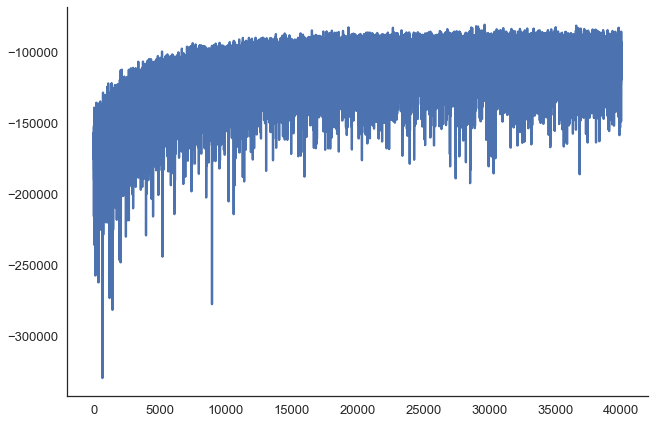

In [9]:
plt.plot(v_params.elbo_vals[10000:])
sns.despine()

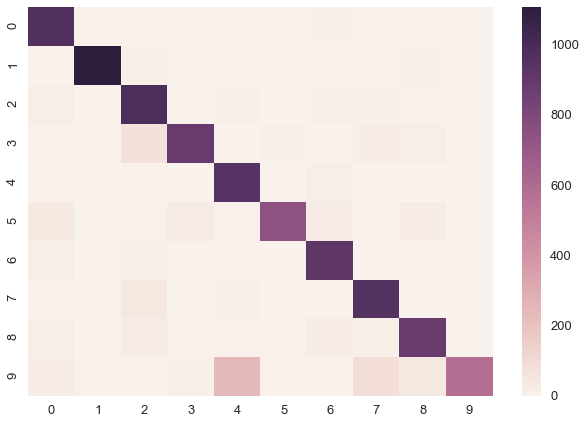

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [11]:
print('Accuracy on test data = {}%'.format(accuracy_score(y_test, y_pred) * 100))

Accuracy on test data = 89.81%


The performance is not incredibly high but hey, it seems to actually work.

## Hierarchical Neural Network: Learning Regularization from data

The connection between the standard deviation of the weight prior to the strengh of the L2 penalization term leads to an interesting idea. Above we just fixed `sd=0.1` for all layers, but maybe the first layer should have a different value than the second. And maybe `0.1` is too small or too large to begin with. In Bayesian modeling it is quite common to just place hyperpriors in cases like this and learn the optimal regularization to apply from the data. This saves us from tuning that parameter in a costly hyperparameter optimization. For more information on hierarchical modeling, see my other [blog post]().

In [26]:
class GaussWeightsHierarchicalRegularization(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        
        regularization = pm.HalfNormal('reg_hyper%d' % self.count, sd=1)
        
        return pm.Normal('w%d' % self.count, mu=0, sd=regularization, 
                         testval=np.random.normal(size=shape),
                         shape=shape)
    
minibatches = zip(
    create_minibatch(X_train, 500),
    create_minibatch(y_train, 500),
)

In [27]:
with pm.Model() as neural_network_hier:
    likelihood = build_ann(GaussWeightsHierarchicalRegularization())
    v_params, trace, ppc, y_pred = run_advi(likelihood)

Average ELBO = -110,551.60: 100%|██████████| 50000/50000 [4:46:04<00:00,  2.74it/s]  
Finished minibatch ADVI: ELBO = -107,691.92
100%|██████████| 100/100 [01:56<00:00,  1.15s/it]


In [28]:
print('Accuracy on test data = {}%'.format(accuracy_score(y_test, y_pred) * 100))

Accuracy on test data = 92.25999999999999%


We get a small but nice boost in accuracy. Let's look at the posteriors of our hyperparameters:

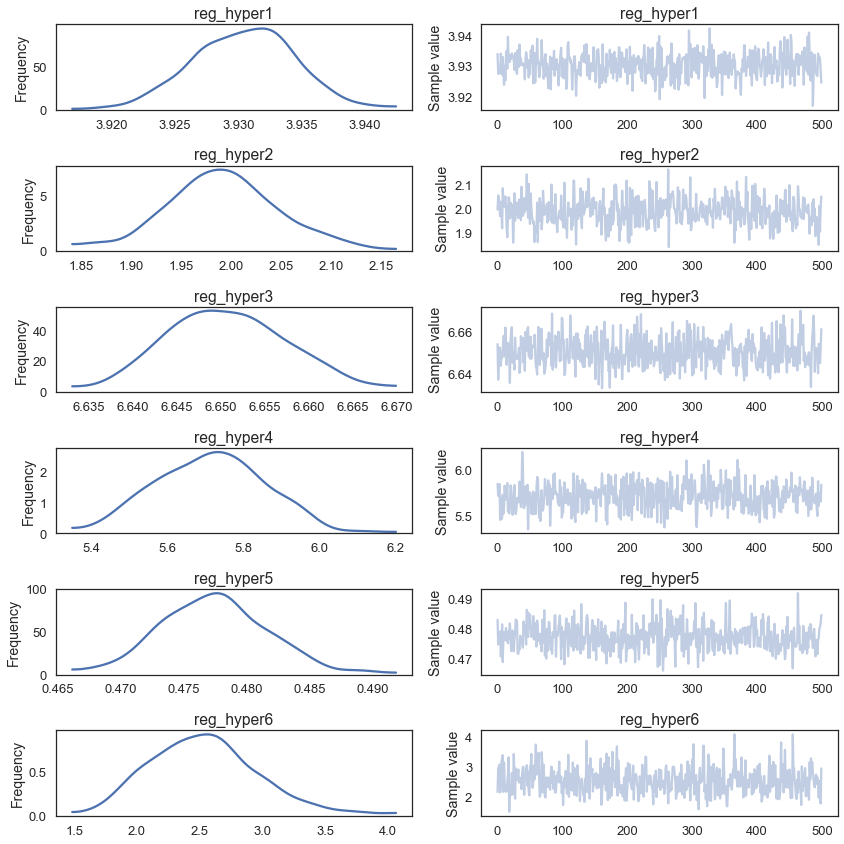

In [29]:
pm.traceplot(trace, varnames=['reg_hyper1', 'reg_hyper2', 'reg_hyper3', 'reg_hyper4', 'reg_hyper5', 'reg_hyper6']);

Interestingly, they all are pretty different suggesting that it makes sense to change the amount of regularization that gets applied at each layer of the network.

## Convolutional Neural Network

This is pretty nice but everything so far would have also been pretty simple to implement directly in `PyMC3` as I have shown in my previous post. Where things get really interesting, is that we can now build way more complex ANNs, like Convolutional Neural Nets:

In [14]:
def build_ann_conv(init):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)

    network = lasagne.layers.Conv2DLayer(
            network, num_filters=32, filter_size=(5, 5),
            nonlinearity=lasagne.nonlinearities.tanh,
            W=init)

    # Max-pooling layer of factor 2 in both dimensions:
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    # Another convolution with 32 5x5 kernels, and another 2x2 pooling:
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.tanh,
        W=init)
    
    network = lasagne.layers.MaxPool2DLayer(network, 
                                            pool_size=(2, 2))
    
    n_hid2 = 256
    network = lasagne.layers.DenseLayer(
        network, num_units=n_hid2,
        nonlinearity=lasagne.nonlinearities.tanh,
        b=init,
        W=init
    )

    # Finally, we'll add the fully-connected output layer, of 10 softmax units:
    network = lasagne.layers.DenseLayer(
        network, num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax,
        b=init,
        W=init
    )
    
    prediction = lasagne.layers.get_output(network)
    
    return pm.Categorical('out', 
                   prediction,
                   observed=target_var)

In [15]:
with pm.Model() as neural_network_conv:
    likelihood = build_ann_conv(GaussWeights())
    v_params, trace, ppc, y_pred = run_advi(likelihood, advi_iters=50000)

Average ELBO = -20,160.79: 100%|██████████| 50000/50000 [12:39:53<00:00,  1.21it/s]     
Finished minibatch ADVI: ELBO = -18,618.35
100%|██████████| 100/100 [09:26<00:00,  5.52s/it]


In [16]:
print('Accuracy on test data = {}%'.format(accuracy_score(y_test, y_pred) * 100))

Accuracy on test data = 98.03%


Much higher accuracy -- nice. I also tried this with the hierarchical model but it achieved lower accuracy (95%), I assume due to overfitting.

Lets make more use of the fact that we're in a Bayesian framework and explore uncertainty in our predictions. As our predictions are categories, we can't simply compute the posterior predictive standard deviation. Instead, we compute the [chi-square statistic](https://en.wikipedia.org/wiki/Chi-squared_test) which tells us how uniform a sample is. The more uniform, the higher our uncertainty. I'm not quite sure if this is the best way to do this, leave a comment if there's a more established method that I don't know about.

In [17]:
miss_class = np.where(y_test != y_pred)[0]
corr_class = np.where(y_test == y_pred)[0]

In [18]:
preds = pd.DataFrame(ppc['out']).T

In [19]:
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')

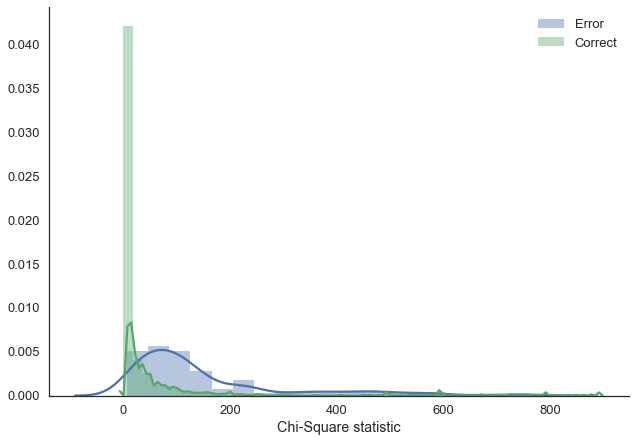

In [22]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square statistic');

As we can see, when the model makes an error, it is much more uncertain in the answer (i.e. the answers provided are more uniform). You might argue, that you get the same effect with a multinomial prediction from a regular ANN, however, [this is not so](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html).

## Conclusions

By bridging `Lasagne` and `PyMC3` and by using mini-batch ADVI to train a Bayesian Neural Network on a decently sized and complex data set (MNIST) we took a big step towards practical Bayesian Deep Learning on real-world problems.

Kudos to the `Lasagne` developers for designing their API to make it trivial to integrate for this unforseen application. They were also very helpful and forthcoming in getting this to work.

Finally, I also think this shows the benefits of `PyMC3`. By relying on a commonly used language (Python) and abstracting the computational backend (`Theano`) we were able to quite easily leverage the power of that ecosystem and use `PyMC3` in a manner that was never thought about when creating it. I look forward to extending it to new domains.

This blog post was written in a Jupyter Notebook. You can get access the notebook [here](https://github.com/twiecki/twiecki.github.io/blob/master/downloads/notebooks/bayesian_neural_network_lasagne.ipynb) and [follow me on Twitter](https://twitter.com/twiecki) to stay up to date.